# Time Causal VAE

In [4]:
%load_ext autoreload
%autoreload 2
import sys
import yaml
sys.path.append('../src')
sys.path.append('../../../..')
# sys.path.append('../../../')

from tsvae.utils.logger_utils import get_console_logger
logger = get_console_logger(__name__)
from os import path as pt
from experiments.experiment_utils import get_output_dir, update_config
from tsvae.dataset.data_pipeline import DataPipeline
from tsvae.models.network_pipeline import NetworkPipeline
from tsvae.utils.random_utils import set_seed
from tsvae.trainers.base_trainer_config import BaseTrainerConfig
from tsvae.trainers.training_pipeline import TrainingPipeline
from evaluations.hyperparameter import ModelEvaluator
from os import path as pt
import pandas as pd
import numpy as np

from data_processing.post_processing import post_processing
from data_processing.config import post_processing_config
from models.DeepHedger import hedging
import wandb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load validation data

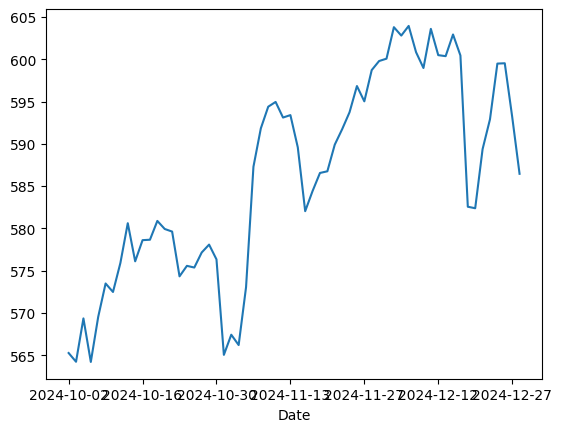

In [9]:
val_data = pd.read_csv("../../../../../data/raw/spy_daily_closing_prices_val.csv", index_col=0)

val_data = val_data["Close"]
val_data.plot(use_index=True)
val_data = np.array([val_data.values[i:i+30] for i in range(len(val_data)-30 + 1)])
val_data = pd.DataFrame(val_data)
val_data = val_data.div(val_data.iloc[:, 0], axis=0)

## TCVAE Model

In [10]:
wandb.login(key="52ea61320bbc9ee2b773e909700366e65977cd0f")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/sondrerogde/.netrc


True

In [11]:
sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'loss',
        'goal': 'minimize'
    },
    'parameters': {
        'learning_rate': {
            'distribution': 'uniform',
            'min': 0.0001,
            'max': 0.02
        },
        'E_hidden_dim': {
            'values': [8, 16, 32]
        },
        'E_num_layers': {
            'values': [1, 2, 3]
        },
        'D_hidden_dim': {
            'values': [8, 16, 32]
        },
        'D_num_layers': {
            'values': [1, 2, 3]
        }
    }
}

In [12]:
sweep_id = wandb.sweep(sweep_config, project="tcvae_hyperopt")

Create sweep with ID: w5h7em3n
Sweep URL: https://wandb.ai/sarogde-ntnu/tcvae_hyperopt/sweeps/w5h7em3n


In [18]:
def objective(config): 
    base_output_dir = '..' 

    new_config = {
        'epochs' : 100, 'wandb': False, 'comment': 'test',
        "D_hidden_dim": config.D_hidden_dim,
        "D_num_layers": config.D_num_layers,
        "E_hidden_dim": config.E_hidden_dim,
        "E_num_layers": config.E_num_layers,
        "learning_rate": config.learning_rate
    }
    exp_config_path = '../configs/Master/betacvae.yaml'

    with open(exp_config_path) as file:
        exp_config = dict(yaml.safe_load(file))

    exp_config = update_config(exp_config, new_config)


    exp_config.base_output_dir = base_output_dir
    exp_config.output_dir = get_output_dir(exp_config)
    logger.info(f"Experiment results saved to {exp_config.output_dir}")

    logger.info(f"Saving experiment config to {exp_config.output_dir}")
    config_file_path = pt.join(exp_config.output_dir, "exp_config.yaml")
    with open(config_file_path, "w") as outfile:
        yaml.dump(exp_config, outfile, default_flow_style=False)
    # logger.info(exp_config)

    # Generating data
    logger.info(f"Setting ramdom seed: {exp_config.seed}")
    set_seed(exp_config.seed)

    data_pipeline = DataPipeline()
    train_dataset, eval_dataset = data_pipeline(exp_config)

    network_pipeline = NetworkPipeline()
    model = network_pipeline(exp_config)

    training_config = BaseTrainerConfig(
    output_dir=exp_config.output_dir,
    learning_rate=exp_config.lr,
    per_device_train_batch_size=exp_config.train_batch_size,
    per_device_eval_batch_size=exp_config.eval_batch_size,
    optimizer_cls=exp_config.optimizer,
    optimizer_params=None,
    scheduler_cls=None,
    scheduler_params=None,
    steps_saving=exp_config.steps_saving,
    steps_predict=exp_config.steps_predict,
    seed=exp_config.seed,
    num_epochs=exp_config.epochs,
    wandb_callback=exp_config.wandb,
    wandb_output_dir=exp_config.base_output_dir + "/wandb")


    # Train TCVAE
    train_pipeline = TrainingPipeline(model=model, training_config=training_config, exp_config=exp_config)

    trainer = train_pipeline(
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        device_name=exp_config.device_name,
    )

    train_pipeline.train(log_output=False)

    # Generate data
    print("Setup generating data")
    model_dir = pt.join(trainer.training_dir, 'final_model')
    model_evaluator = ModelEvaluator(model_dir)
    output_dir = model_evaluator.hyper_model_dir
    model = model_evaluator.model

    df_tot_fake = pd.DataFrame()
    # 100 times 1000 corresponds to M = 100.000
    print("Generating data")
    for i in range(100):
        test_data, gen_data, recon_data = model_evaluator.load_data(seed = i, n_sample_test=1000)
        ds = model_evaluator.data_ppl.base_dataset

        real_data = test_data
        recon_data = recon_data
        fake_data = gen_data

        df_sub_fake = pd.DataFrame(gen_data.detach().squeeze(-1).numpy())
        df_tot_fake = pd.concat([df_tot_fake, df_sub_fake], axis=0)

    print("Post-processing")
    df_tot_fake = df_tot_fake.reset_index(drop=True)
    # Post-processing
    df_post_processed = post_processing(df_tot_fake, **post_processing_config)
    
    print("Hedging")
    # Hedging
    val_loss = hedging(df_post_processed, val_data)

    return val_loss


def main():
    wandb.init()
    val_loss = objective(wandb.config)
    wandb.log({"val_loss": val_loss,  "loss": val_loss})

In [ ]:
wandb.agent(sweep_id, function=main, count=30, project="tcvae_hyperopt")

wandb: Agent Starting Run: gjmn0oo1 with config:
wandb: 	D_hidden_dim: 8
wandb: 	D_num_layers: 1
wandb: 	E_hidden_dim: 32
wandb: 	E_num_layers: 2
wandb: 	learning_rate: 0.004650826131404842


Experiment results saved to ../results/Master_timestep_30/model_BetaCVAE_De_CLSTMRes_En_CLSTMRes_Prior_RealNVP_Con_Id_Dis_None_comment_test
Experiment results saved to ../results/Master_timestep_30/model_BetaCVAE_De_CLSTMRes_En_CLSTMRes_Prior_RealNVP_Con_Id_Dis_None_comment_test
Experiment results saved to ../results/Master_timestep_30/model_BetaCVAE_De_CLSTMRes_En_CLSTMRes_Prior_RealNVP_Con_Id_Dis_None_comment_test
Saving experiment config to ../results/Master_timestep_30/model_BetaCVAE_De_CLSTMRes_En_CLSTMRes_Prior_RealNVP_Con_Id_Dis_None_comment_test
Saving experiment config to ../results/Master_timestep_30/model_BetaCVAE_De_CLSTMRes_En_CLSTMRes_Prior_RealNVP_Con_Id_Dis_None_comment_test
Saving experiment config to ../results/Master_timestep_30/model_BetaCVAE_De_CLSTMRes_En_CLSTMRes_Prior_RealNVP_Con_Id_Dis_None_comment_test
Setting ramdom seed: 0
Setting ramdom seed: 0
Setting ramdom seed: 0
Base dataset initialized
Path Visualization of data
Model passed sanity check !
Ready for t